In [1]:
import pandas as pd
X_train = pd.read_csv('features_train_scaled.csv')
X_test = pd.read_csv('features_test_scaled.csv')
y_train = pd.read_csv('target_train.csv')
y_test = pd.read_csv('target_test.csv')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

# setup data
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# MLP w/ dropout
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.drop1(self.relu1(self.fc1(x)))
        x = self.drop2(self.relu2(self.fc2(x)))
        x = self.sigmoid(self.output(x))
        return x

# lowering learning rate significantly helped with stability
lr = 1e-5
batch_size = 32
epochs = 50

model = MLP(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
val_accuracies = []
val_f1s = []

# training
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    # validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_preds_binary = (val_preds > 0.5).float()

        acc = accuracy_score(y_test_tensor.numpy(), val_preds_binary.numpy())
        f1 = f1_score(y_test_tensor.numpy(), val_preds_binary.numpy())
        val_accuracies.append(acc)
        val_f1s.append(f1)

# print output
print(f"\nFinal Accuracy: {val_accuracies[-1]:.4f}")
print(f"Final F1 Score: {val_f1s[-1]:.4f}")
print("\nDetailed Report:")
print(classification_report(y_test_tensor.numpy(), val_preds_binary.numpy()))


Epoch 1/50 - Loss: 0.6877
Epoch 11/50 - Loss: 0.5722
Epoch 21/50 - Loss: 0.5472
Epoch 31/50 - Loss: 0.5447
Epoch 41/50 - Loss: 0.5424
Epoch 50/50 - Loss: 0.5432

Final Accuracy: 0.7252
Final F1 Score: 0.7311

Detailed Report:
              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72       970
         1.0       0.73      0.73      0.73      1006

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976



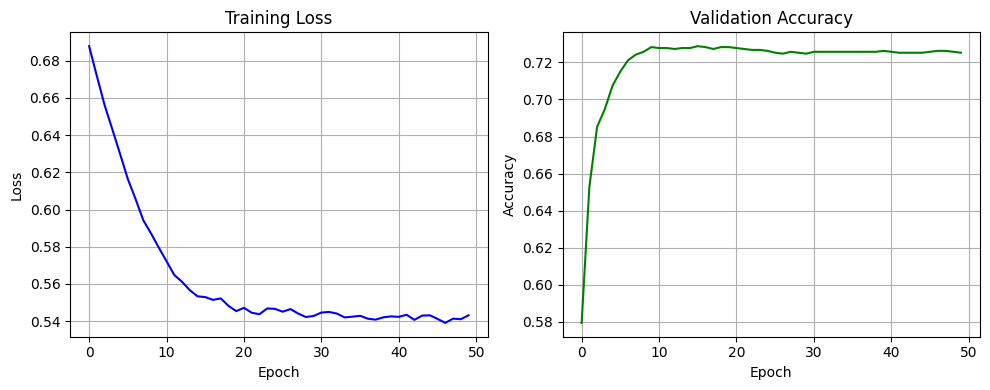

In [9]:
# training loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()